# 🐟 Multiclass Fish Image Classification

This notebook trains a CNN and multiple transfer learning models to classify fish species from images.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [3]:
# path
train_path = '/content/drive/MyDrive/Dataset/images/data/train'
test_path = '/content/drive/MyDrive/Dataset/images/data/test'
valid_path = '/content/drive/MyDrive/Dataset/images/data/val'
# Image size and batch
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

Data Preprocessing and Augmentation

Train data needs variety (augment), Test data needs clarity (just rescale)
<br>
These tricks helps our model see different versions of the same image — this is called Data Augmentation. It makes the model stronger and better at generalizing.

For test data, we don’t use flips or rotations — we just rescale. Test data should be clean.

In [4]:
# Data generators for train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
valid_generator = test_val_datagen.flow_from_directory(valid_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator  = test_val_datagen.flow_from_directory(test_path, target_size=IMG_SIZE, batch_size=1, class_mode='categorical', shuffle=False)

num_classes = len(train_generator.class_indices)


Found 6256 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


 CNN model built from scratch

In [5]:

def build_cnn_model():
    model = Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
history_cnn = cnn_model.fit(train_generator, validation_data=valid_generator, epochs=10)
cnn_model.save("cnn_fish_model.h5") #Saves model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1983s 10s/step - accuracy: 0.2786 - loss: 2.5465 - val_accuracy: 0.6264 - val_loss: 1.1802
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 134s 584ms/step - accuracy: 0.5048 - loss: 1.3757 - val_accuracy: 0.7033 - val_loss: 0.9040
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 117s 596ms/step - accuracy: 0.6087 - loss: 1.1022 - val_accuracy: 0.7756 - val_loss: 0.7468
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 115s 586ms/step - accuracy: 0.6598 - loss: 0.9727 - val_accuracy: 0.7601 - val_loss: 0.6291
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 116s 592ms/step - accuracy: 0.7365 - loss: 0.7692 - val_accuracy: 0.8407 - val_loss: 0.4744
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 115s 588ms/step - accuracy: 0.7422 - loss: 0.7359 - val_accuracy: 0.8828 - val_loss: 0.3914
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 116s 591ms/step - accuracy: 0.7688 - loss: 0.6524 - val_accuracy: 0.8965 - val_loss: 0.3561
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 115s 583ms/step - accuracy: 0.7712 - 

In [6]:

def build_transfer_model(base_model_class):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Transfer Learning with 5 pre-trained models:
- VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0

In [7]:
models_dict = {
    "VGG16": VGG16,
    "ResNet50": ResNet50,
    "MobileNetV2": MobileNetV2,
    "InceptionV3": InceptionV3,
    "EfficientNetB0": EfficientNetB0
}

histories = {}
for name, model_class in models_dict.items():
    print(f"\nTraining {name}...")
    model = build_transfer_model(model_class)
    history = model.fit(train_generator, validation_data=valid_generator, epochs=5)
    model.save(f"{name}_fish_model.h5")
    histories[name] = history



Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 148s 683ms/step - accuracy: 0.1411 - loss: 2.4065 - val_accuracy: 0.2665 - val_loss: 2.1294
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 128s 652ms/step - accuracy: 0.2552 - loss: 2.1050 - val_accuracy: 0.4826 - val_loss: 1.9209
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 122s 622ms/step - accuracy: 0.3606 - loss: 1.9337 - val_accuracy: 0.5797 - val_loss: 1.7601
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 123s 629ms/step - accuracy: 0.4641 - loss: 1.7639 - val_accuracy: 0.6172 - val_loss: 1.6056
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 122s 623ms/step - accuracy: 0.5332 - loss: 1.6545 - val_accuracy: 0.7106 - val_loss: 1.4572



Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 142s 658ms/step - accuracy: 0.1314 - loss: 2.4450 - val_accuracy: 0.1603 - val_loss: 2.2907
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 118s 601ms/step - accuracy: 0.1681 - loss: 2.3148 - val_accuracy: 0.1703 - val_loss: 2.2539
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 121s 615ms/step - accuracy: 0.1793 - loss: 2.2839 - val_accuracy: 0.1786 - val_loss: 2.2225
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 117s 596ms/step - accuracy: 0.1777 - loss: 2.2616 - val_accuracy: 0.1694 - val_loss: 2.2041
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 120s 613ms/step - accuracy: 0.1919 - loss: 2.2173 - val_accuracy: 0.1758 - val_loss: 2.1873



Training MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 133s 626ms/step - accuracy: 0.3877 - loss: 1.8263 - val_accuracy: 0.8901 - val_loss: 0.5521
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 129s 592ms/step - accuracy: 0.8468 - loss: 0.5642 - val_accuracy: 0.9341 - val_loss: 0.2979
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 114s 584ms/step - accuracy: 0.9199 - loss: 0.3206 - val_accuracy: 0.9542 - val_loss: 0.1893
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 114s 581ms/step - accuracy: 0.9367 - loss: 0.2413 - val_accuracy: 0.9606 - val_loss: 0.1517
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 140s 574ms/step - accuracy: 0.9456 - loss: 0.1912 - val_accuracy: 0.9652 - val_loss: 0.1187



Training InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 152s 690ms/step - accuracy: 0.3928 - loss: 1.8633 - val_accuracy: 0.8571 - val_loss: 0.5205
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 117s 595ms/step - accuracy: 0.8240 - loss: 0.5758 - val_accuracy: 0.9158 - val_loss: 0.3083
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 118s 602ms/step - accuracy: 0.8845 - loss: 0.3730 - val_accuracy: 0.9277 - val_loss: 0.2352
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 117s 598ms/step - accuracy: 0.9066 - loss: 0.2961 - val_accuracy: 0.9304 - val_loss: 0.2126
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 143s 602ms/step - accuracy: 0.9153 - loss: 0.2617 - val_accuracy: 0.9533 - val_loss: 0.1600



Training EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 162s 722ms/step - accuracy: 0.1556 - loss: 2.3389 - val_accuracy: 0.1712 - val_loss: 2.3120
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 114s 581ms/step - accuracy: 0.1802 - loss: 2.2979 - val_accuracy: 0.1712 - val_loss: 2.3105
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 128s 651ms/step - accuracy: 0.1767 - loss: 2.3101 - val_accuracy: 0.1712 - val_loss: 2.3121
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 120s 611ms/step - accuracy: 0.1734 - loss: 2.3058 - val_accuracy: 0.1712 - val_loss: 2.3115
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 114s 581ms/step - accuracy: 0.1685 - loss: 2.3097 - val_accuracy: 0.1712 - val_loss: 2.3130


Evaluation using Accuracy, Confusion Matrix, and Classification Report

3187/3187 ━━━━━━━━━━━━━━━━━━━━ 1068s 335ms/step
Classification Report for CNN:
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.98      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.84      0.99      0.91       298
   fish sea_food gilt_head_bream       0.93      0.58      0.71       305
   fish sea_food hourse_mackerel       0.87      0.95      0.91       286
        fish sea_food red_mullet       0.99      0.95      0.97       291
     fish sea_food red_sea_bream       0.69      0.91      0.79       273
          fish sea_food sea_bass       0.82      0.85      0.83       327
            fish sea_food shrimp       0.90      1.00      0.95       289
fish sea_food striped_red_mullet       0.94      0.81      0.87       293
             fish sea_food trout       0.98      0.86      0.92       292

                        accurac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


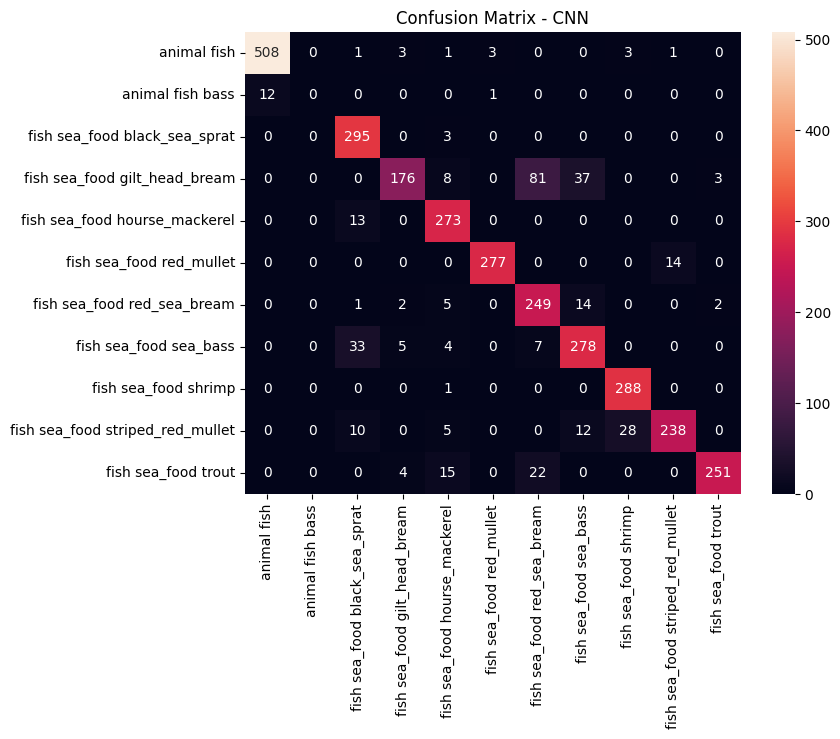

3187/3187 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step
Classification Report for VGG16:
                                  precision    recall  f1-score   support

                     animal fish       0.96      0.98      0.97       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.80      0.77      0.78       298
   fish sea_food gilt_head_bream       0.85      0.17      0.28       305
   fish sea_food hourse_mackerel       0.55      0.89      0.68       286
        fish sea_food red_mullet       0.49      0.60      0.54       291
     fish sea_food red_sea_bream       0.71      0.75      0.73       273
          fish sea_food sea_bass       0.90      0.54      0.68       327
            fish sea_food shrimp       0.66      0.96      0.78       289
fish sea_food striped_red_mullet       0.55      0.53      0.54       293
             fish sea_food trout       0.82      0.87      0.84       292

                        accuracy

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


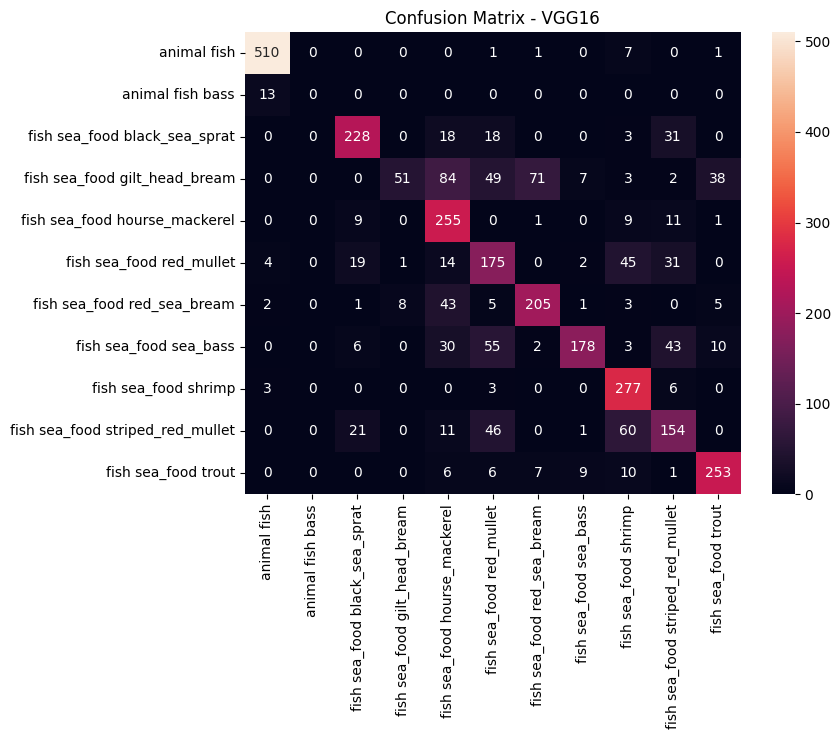

3187/3187 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step
Classification Report for ResNet50:
                                  precision    recall  f1-score   support

                     animal fish       0.23      0.73      0.35       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.08      0.25      0.12       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.14      0.26      0.18       327
            fish sea_food shrimp       0.12      0.00      0.01       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00      0.00       292

                        accur

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


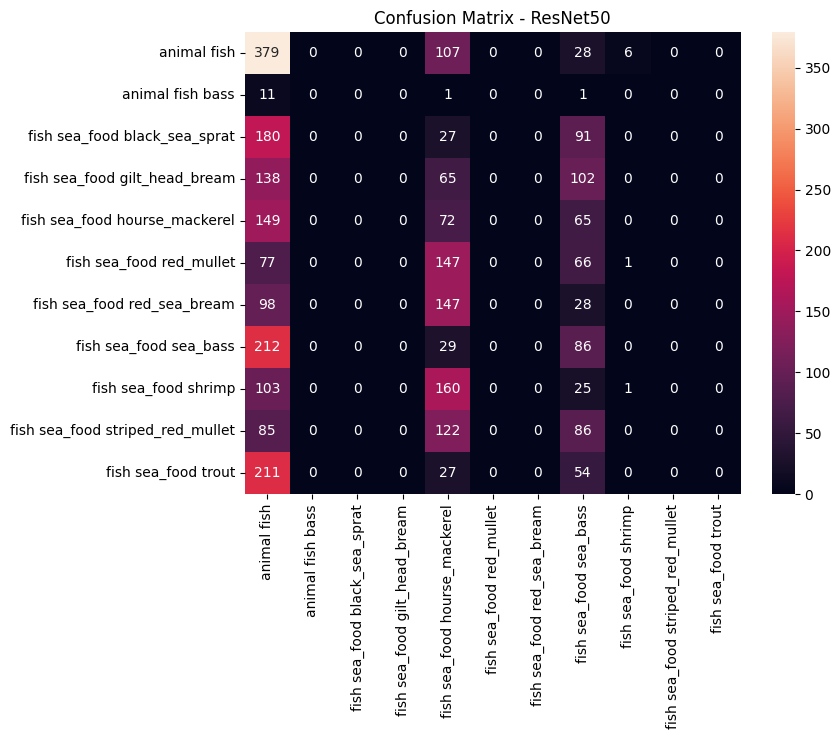

3187/3187 ━━━━━━━━━━━━━━━━━━━━ 86s 26ms/step
Classification Report for MobileNetV2:
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.99      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.99      0.99      0.99       298
   fish sea_food gilt_head_bream       0.95      0.98      0.96       305
   fish sea_food hourse_mackerel       1.00      0.99      0.99       286
        fish sea_food red_mullet       1.00      0.96      0.98       291
     fish sea_food red_sea_bream       0.98      0.99      0.99       273
          fish sea_food sea_bass       0.96      1.00      0.98       327
            fish sea_food shrimp       0.99      1.00      0.99       289
fish sea_food striped_red_mullet       0.94      0.99      0.96       293
             fish sea_food trout       1.00      0.93      0.96       292

                        ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


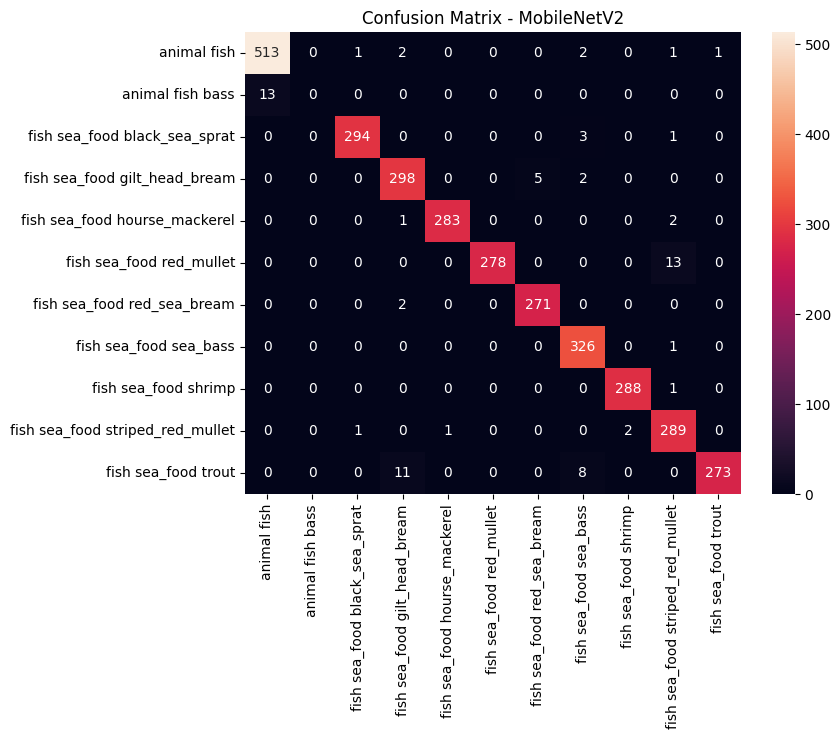

3187/3187 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step
Classification Report for InceptionV3:
                                  precision    recall  f1-score   support

                     animal fish       0.97      0.99      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.96      0.98      0.97       298
   fish sea_food gilt_head_bream       0.96      0.99      0.97       305
   fish sea_food hourse_mackerel       0.96      0.97      0.97       286
        fish sea_food red_mullet       0.98      0.96      0.97       291
     fish sea_food red_sea_bream       0.99      0.97      0.98       273
          fish sea_food sea_bass       0.97      0.91      0.94       327
            fish sea_food shrimp       0.99      0.99      0.99       289
fish sea_food striped_red_mullet       0.91      0.92      0.92       293
             fish sea_food trout       0.96      1.00      0.98       292

                        ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


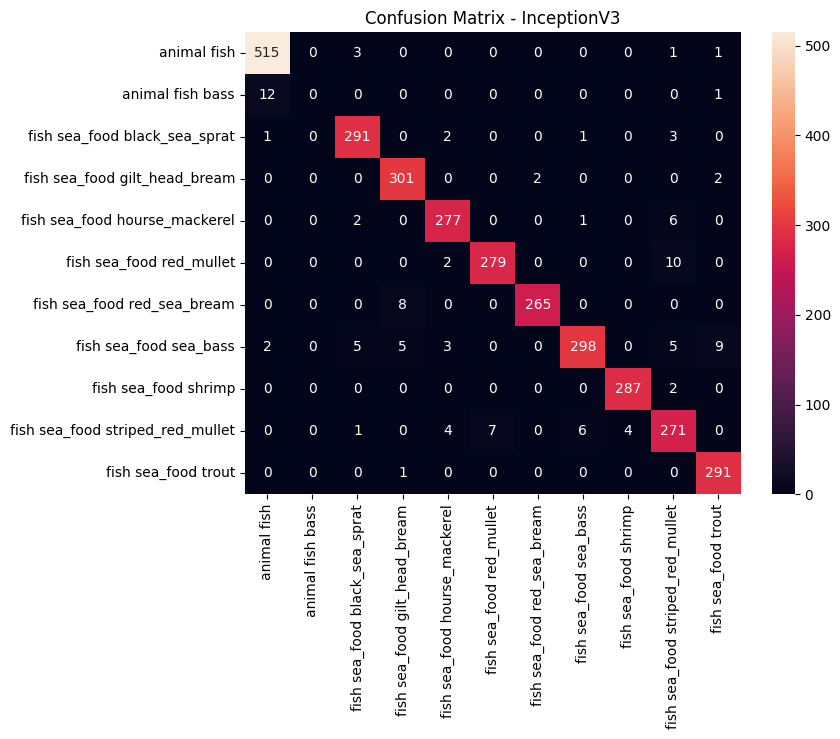

3187/3187 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step
Classification Report for EfficientNetB0:
                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00      0.00       292

                        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


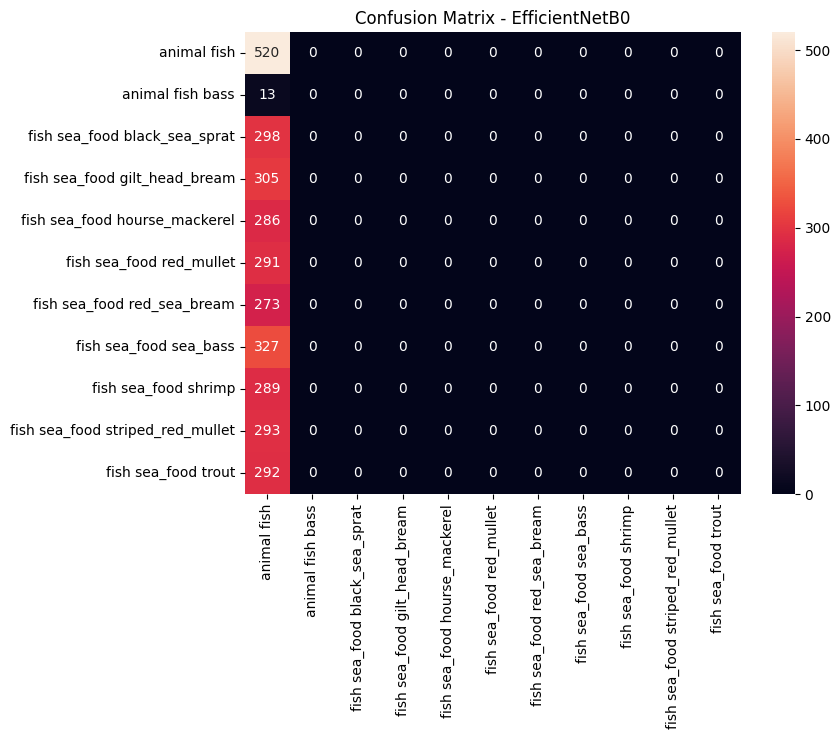

In [8]:

def evaluate_model(model_path, model_name):
    model = tf.keras.models.load_model(model_path)
    preds = model.predict(test_generator)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_generator.classes

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Evaluate all models
evaluate_model("cnn_fish_model.h5", "CNN")
for name in models_dict.keys():
    evaluate_model(f"{name}_fish_model.h5", name)
